In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from pyrcn.echo_state_network import ESNRegressor
from sklearn.model_selection import train_test_split

In [2]:
a = [0.1]
b = [0.2]
for _ in range(10):
    new_a = a[-1] * (3.78 - 3.78 * a[-1])
    new_b = b[-1] * (3.77 - 3.77 * b[-1])
    a.append(new_a)
    b.append(new_b)

for _ in range(20000):
    new_a = a[-1] * (3.78 - 3.78 * a[-1])
    new_y = b[-1] * (3.77 - 3.77 * b[-1] - 0.8 * a[-10])
    a.append(new_a)
    b.append(new_y)

a = np.array(a)
b = np.array(b)

In [3]:
lags = list(range(1, 21))
a_b_corrs = []
for lag in lags:
    # lag the a time series
    a_lagged = a[:-lag]
    b_lagged = b[lag:]

    # split into train and test
    features_ = a_lagged.reshape(-1, 1)
    predicted = b_lagged
    X_train, X_test, y_train, y_test = train_test_split(features_, predicted, test_size=0.4, shuffle=False)

    # fit and predict
    reg = ESNRegressor(hidden_layer_size=50)
    reg.fit(X=X_train, y=y_train)
    y_pred = reg.predict(X_test)

    # score
    corr = np.corrcoef(y_test[100:], y_pred[100:])[0, 1]
    # print(f"lag: {lag:2}   correlation: {corr:.3f}")
    a_b_corrs.append(corr)

b_a_corrs = []
for lag in lags:
    # lag the a time series
    a_lagged = a[:-lag]
    b_lagged = b[lag:]

    # split into train and test
    features_ = b_lagged.reshape(-1, 1)
    predicted = a_lagged
    X_train, X_test, y_train, y_test = train_test_split(features_, predicted, test_size=0.4, shuffle=False)

    # fit and predict
    reg = ESNRegressor(hidden_layer_size=50)
    reg.fit(X=X_train, y=y_train)
    y_pred = reg.predict(X_test)

    # score
    corr = np.corrcoef(y_test[100:], y_pred[100:])[0, 1]
    # print(f"lag: {lag:2}   correlation: {corr:.3f}")
    b_a_corrs.append(corr)

Text(0, 0.5, 'correlation')

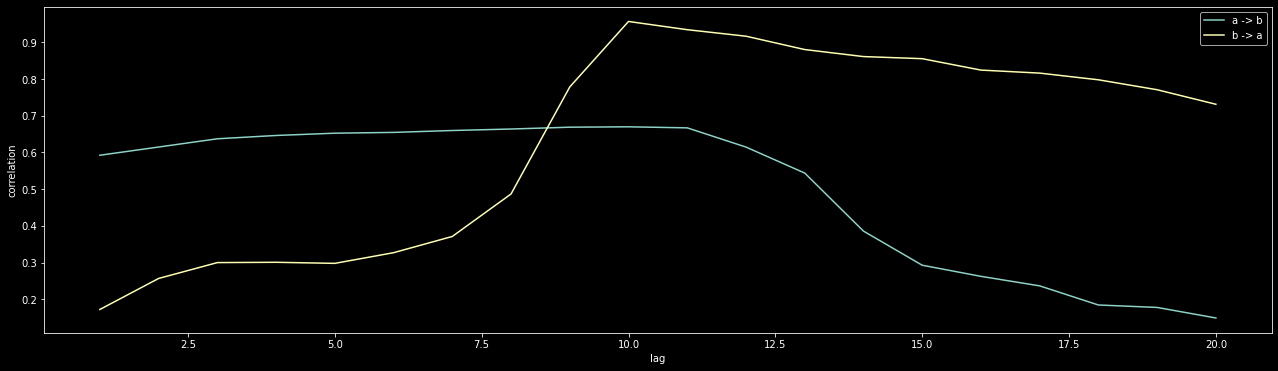

In [4]:
plt.figure(figsize=(22, 6))
plt.plot(lags, a_b_corrs, label="a -> b")
plt.plot(lags, b_a_corrs, label="b -> a")
plt.legend()
plt.xlabel("lag")
plt.ylabel("correlation")

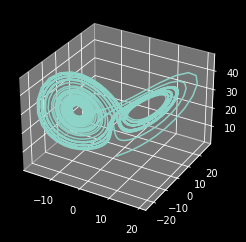

In [5]:
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D

rho = 28.0
sigma = 10.0
beta = 8.0 / 3.0

def f(state, t):
    x, y, z = state  # Unpack the state vector
    return sigma * (y - x), x * (rho - z) - y, x * y - beta * z  # Derivatives

state0 = [1.0, 1.0, 1.0]
t = np.arange(0.0, 40.0, 0.02)

states = odeint(f, state0, t)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(states[:, 0], states[:, 1], states[:, 2])

a, b, c = states[:, 0], states[:, 1], states[:, 2]

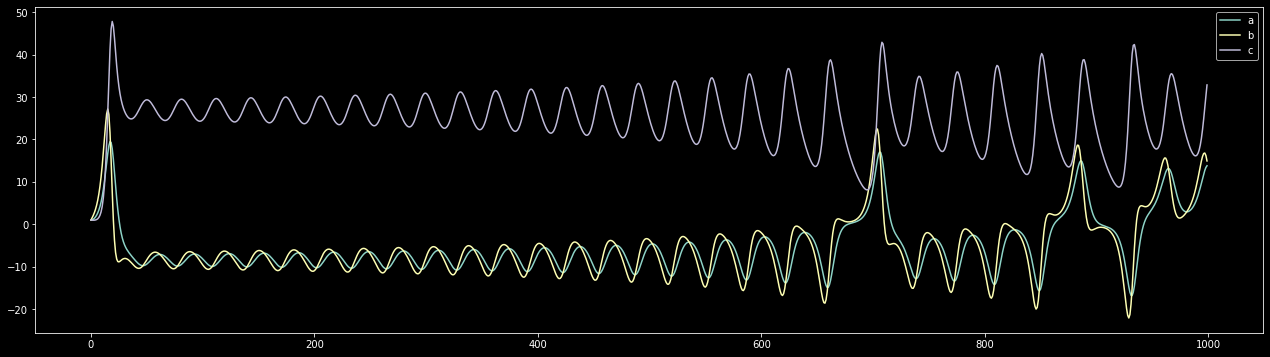

In [6]:
plt.figure(figsize=(22, 6))
plt.plot(a[:1000], label='a')
plt.plot(b[:1000], label='b')
plt.plot(c[:1000], label='c')
plt.legend()

In [7]:
# split into train and test
features_ = np.stack((c, b), axis=1)
predicted = a
X_train, X_test, y_train, y_test = train_test_split(features_, predicted, test_size=0.4, shuffle=False)

# fit and predict
reg = ESNRegressor(hidden_layer_size=50)
reg.fit(X=X_train, y=y_train)
y_pred = reg.predict(X_test)

# score
corr = np.corrcoef(y_test[100:], y_pred[100:])[0, 1]
corr

0.9659575640430197

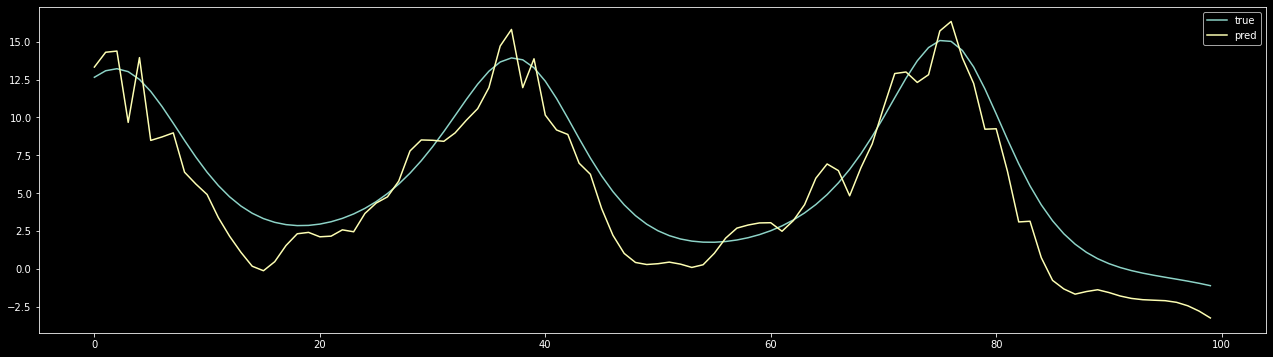

In [11]:
plt.figure(figsize=(22, 6))
# plt.plot(y_test[:100])
# plt.plot(y_pred[:100])
plt.plot(y_test[100:200], label='true')
plt.plot(y_pred[100:200], label='pred')
plt.legend()